This notebook talks in detail the technical and mathematical aspects of one of the applications of the Variational Classifier type of hybrid models. In this notebook, a variational classifier is modeled to take as input four parameters:

1. Sepal Length
2. Sepal Width

The output of this hybrid model, being a binary classifier, classifies the two input parameters into two types of Iris. For the purpose of this example, a subset of the original Iris Model is taken. The two unique output text labels are assigned the binary values 0 and 1.

The general structure of a Variational Quantum Classifier can be seen as:
![title](images/VQC.png)
Credit: Plos One

### 0. Initialization

We first initialize the required libraries for using the in-built functions and simulating the Quantum Circuits that will be developed.

Pennylane is used for its very intuitive design of the functions and their ease to use. The in-built numpy library is also imported to later use the back-propagation feature for weights optimization during the training process.

In [5]:
import pennylane as qml
import pennylane.numpy as np

dev = qml.device('default.qubit')

### 1. Feature Map

This stage of the VQC model does the function of preparaing the classical data in a form which is compatible for processing by the Quantum Circuit. This stage can also be referred to as the State Preparation stage which is explained by the purpose it serves.

There are many ways of designing the state preparation stage and it depends on the type of input data. Some of the types are Binary Embedding, QAOA Embedding, Angular Embedding. In this case, the data type if of the form float32. Therefore, an appropriate embedding method would be Angular Embedding.

This is the reason why Angular Embedding method is used. After this, the number of independent input variables is 4. Unlike classical computing, we can speed-up the learning process by using an entanglement of $\log_2 4 = 2$ qubits which would result in a total of 4 entanglement states. This special property of the qubits to get entangled provides us the advantage over classical computing.

After this Quantum Layer is run, the inputs can be visualized as a vectors in one of the XY, YZ or XZ planes in the Bloch Sphere placed in their position at an angle with respect to one of the axes. The state-vector after rotation, when taken components of along the axes of the corresponding 2-D plane, represent the amplitudes of the states of the system. These amplitudes are what we want to encode and these will represent the actual inputs.

Following is the quantum circuit for the state preparation block:

In [6]:
def get_angles(x):
    beta0 = 2 * np.arcsin(np.sqrt(x[1] ** 2) / np.sqrt(x[0] ** 2 + x[1] ** 2 + 1e-12))
    beta1 = 2 * np.arcsin(np.sqrt(x[3] ** 2) / np.sqrt(x[2] ** 2 + x[3] ** 2 + 1e-12))
    beta2 = 2 * np.arcsin(np.linalg.norm(x[2:]) / np.linalg.norm(x))

    return np.array([beta2, -beta1 / 2, beta1 / 2, -beta0 / 2, beta0 / 2])


def state_preparation(a):
    qml.RY(a[0], wires=0)

    qml.CNOT(wires=[0, 1])
    qml.RY(a[1], wires=1)
    qml.CNOT(wires=[0, 1])
    qml.RY(a[2], wires=1)

    qml.PauliX(wires=0)
    qml.CNOT(wires=[0, 1])
    qml.RY(a[3], wires=1)
    qml.CNOT(wires=[0, 1])
    qml.RY(a[4], wires=1)
    qml.PauliX(wires=0)

The circuit defined in the state_preparation function looks like this:
![title](images/state_prep.png)

The vertical lines in the above circuit show the barriers in the circuit. This is how I like to visually understand the circuit. In the image, the notations $\vert \psi_0\rangle$, $\vert \psi_1\rangle$, $\vert \psi_2\rangle$, $\vert \psi_3\rangle$, $\vert \psi_4\rangle$ represent the states of the quantum systems after the four barriers and before the measurement respectively. The notation followed to represent the quantum states is $\vert q_1 q_0\rangle$.

It is very important to understand why the angular embedding circuit is designed this way. Below is the mathematical explaination of the same.

We want the input value to be encoded as a vector in the bloch sphere and should be differentiable from the other states based on the angle which it forms from one of the axes of the 2-D plane it belongs to.

In this example, initially, both the qubits are in the state $\vert 0\rangle$. In the Bloch Sphere, this can be seen as the vecetor aligned along the +ve Z-axis. To encode a qubit with an angle, we can simply apply a controlled rotation perpendicular to the X or Y axes. In this case, since initially, the qubit is aligned along the Z-axis, the controlled gates RY or RX can be applied.

Here, the RY gate is used. Therefore, the rotation will take place perpendicular to the Y-axis, in the ZX plane. The RY gate is represented as:

<div style="text-align: center;">
    $
    R_y(\theta) = \begin{pmatrix}
    \cos \left(\frac{\theta}{2}\right) & -\sin \left(\frac{\theta}{2}\right) \\
    \sin \left(\frac{\theta}{2}\right) & \cos \left(\frac{\theta}{2}\right)
    \end{pmatrix}
    $
</div>

Therefore, the state at $\vert \psi_0\rangle$ can be represented as:

$
\vert \psi_0\rangle = (I\vert q_1\rangle)\bigotimes(R_y(\theta_0)\vert q_0\rangle) = 
\vert 0\rangle\bigotimes
\left(
\begin{pmatrix}
    \cos \left(\frac{\theta_0}{2}\right) & -\sin \left(\frac{\theta_0}{2}\right) \\
    \sin \left(\frac{\theta_0}{2}\right) & \cos \left(\frac{\theta_0}{2}\right)
\end{pmatrix}
\cdot
\begin{pmatrix}
    1 \\
    0
\end{pmatrix}
\right) = 
\vert 0\rangle\bigotimes
\begin{pmatrix}
    \cos \left(\frac{\theta_0}{2}\right) \\
    \sin \left(\frac{\theta_0}{2}\right)
\end{pmatrix} = 
\vert 0\rangle\bigotimes
\left(
\cos \left(\frac{\theta_0}{2}\right)\vert 0\rangle + \sin \left(\frac{\theta_0}{2}\right)\vert 1\rangle
\right)
$

<!-- <div style="text-align: right;"> - (1)</div> -->

The circuit block between the first and second barriers are repeated and hence, it is more convenient to view them as transformation matrices. Following the notation, the operations have to be written from right to left. Hence:

$
BOper(\theta_1, \theta_2) = (R_y(\theta_2)\bigotimes I)\cdot(CNOT)\cdot(R_y(\theta_1)\bigotimes I)\cdot(CNOT)
$

Following the notation of state representation, the CNOT gate will be:

$
CNOT = 
\begin{pmatrix}
    1 & 0 & 0 & 0 \\
    0 & 0 & 0 & 1 \\
    0 & 0 & 1 & 0 \\
    0 & 1 & 0 & 0 \\
\end{pmatrix}
$

$
\therefore BOper(\theta_1, \theta_2) = (R_y(\theta_2)\bigotimes I)\cdot
\begin{pmatrix}
    1 & 0 & 0 & 0 \\
    0 & 0 & 0 & 1 \\
    0 & 0 & 1 & 0 \\
    0 & 1 & 0 & 0 \\
\end{pmatrix}
\cdot(R_y(\theta_1)\bigotimes I)\cdot
\begin{pmatrix}
    1 & 0 & 0 & 0 \\
    0 & 0 & 0 & 1 \\
    0 & 0 & 1 & 0 \\
    0 & 1 & 0 & 0 \\
\end{pmatrix}
$

After the Kronecker product and the matrix multiplications, the operation is:

$
BOper(\theta_1, \theta_2) = 
\begin{pmatrix}
    \cos \left(\frac{\theta_1 + \theta_2}{2}\right) & 0 & -\sin \left(\frac{\theta_1 + \theta_2}{2}\right) & 0 \\
    0 & \cos \left(\frac{\theta_1 - \theta_2}{2}\right) & 0 & \sin \left(\frac{\theta_1 - \theta_2}{2}\right) \\
    \sin \left(\frac{\theta_1 + \theta_2}{2}\right) & 0 & \cos \left(\frac{\theta_1 + \theta_2}{2}\right) & 0 \\
    0 & -\sin \left(\frac{\theta_1 - \theta_2}{2}\right) & 0 & \cos \left(\frac{\theta_1 - \theta_2}{2}\right) \\
\end{pmatrix}
$

At this point, it becomes very important to note how the operatot is designed and how we can use it for our application. Had there been only one variable to encode, the first RY gate could have sufficed. However in our case, there are 2 qubits, and we have two requirements:

1. The second variable should be represented by the system
2. The qubits should be entangled to provide speedup

If in $BOper$, we use $\theta_2 = -\theta_1$, we can see that the resulting matrix puts the second qubit in entanglement with the first qubit along with changing only those states of the system where the state of the second qubit changes. This is exactly what we want as we change the amplitudes of the indivisual states while keeping the entanglement in action. In the first $BOper$, the changes take place with respect to the first qubit in state $\vert 0\rangle$.

In the second $BOper$, we change this by applying the second X gate to make similar changes with respect to the first qubit in state $\vert 1\rangle$.

After getting the parametric form of the final qubit system, we can solve the equations to get the angles of the rotation gates in terms of the required amplitudes. These calculations are done in the get_angles function above.

### 2. Variational Quantum Circuit

The variational circuit is also based on the principle of quantum entanglement to explore all the relational equations between the variables in minimal steps, thus providing the quantum speedup. For this, block, we try to replicate the logical functioning of a classical learning process...

In a classical ML model, during the training process, we initiate a set of random numerical values called the weights and biases. During the learning process, these weights and biases are optimized by an optimizer such that when they operate on the input variables, they convert the input variables into a final form which can be inerpreted into the desired output type.

The variational block does a similar thing. The block starts by operating the input qubits with a set of random angles which can be called weights. Then a set of CNOTs is applied in a cyclic order to bring the neighbouring qubits in entanglement. We quantify this as a layer.

The block is made up of multiple layers and the optimizer, through the training process optimized these weights to fit the dataset. We design the layer as:

In [10]:
def layer(layer_weights):
    for wire in range(2):
        qml.Rot(*layer_weights[wire], wires=wire)
    qml.CNOT(wires=[0, 1])

In [11]:
@qml.qnode(dev)
def circuit(weights, x):
    state_preparation(x)

    for layer_weights in weights:
        layer(layer_weights)

    return qml.expval(qml.PauliZ(0))

In [12]:
def variational_classifier(weights, bias, x):
    return circuit(weights, x) + bias

### 3. Classical Model

We noe define the classical cost function as follows:

In [13]:
def cost(weights, bias, X, Y):
    predictions = variational_classifier(weights, bias, X.T)
    return square_loss(Y, predictions)

The square loss is defined as:

In [14]:
def square_loss(labels, predictions):
    return np.mean((labels - qml.math.stack(predictions)) ** 2)

We also define the accuracy of the model as the ratio of the number of input values for which it gets the correct predictions and total number of inputs:

In [15]:
def accuracy(labels, predictions):
    acc = sum(abs(l - p) < 1e-5 for l, p in zip(labels, predictions))
    acc = acc / len(labels)
    return acc

### 3.1: Data Loading

We now have to load the data and make it compatible for the hybrid model to process on. The output of the dataset is already mapped from {0, 1} $\rightarrow$ {-1, 1} to suite to the Z Pauli gate in the final measurement of the circuit. We pad the vector of input variables to suite for the total 4 possible states of the system.

Normalization is necessary as the input values are neede to be brought onto a similar scale.

In [26]:
data = np.loadtxt("iris_classes1and2_scaled v2.txt")
X = data[:, 0:2]
print(f"First X sample (original)  : {X[0]}")

# pad the vectors to size 2^2=4 with constant values
padding = np.ones((len(X), 2)) * 0.1
X_pad = np.c_[X, padding]
print(f"First X sample (padded)    : {X_pad[0]}")

# normalize each input
normalization = np.sqrt(np.sum(X_pad**2, -1))
X_norm = (X_pad.T / normalization).T
print(f"First X sample (normalized): {X_norm[0]}")

# the angles for state preparation are the features
features = np.array([get_angles(x) for x in X_norm], requires_grad=False)
print(f"First features sample      : {features[0]}")

Y = data[:, -1]

First X sample (original)  : [0.4  0.75]
First X sample (padded)    : [0.4  0.75 0.1  0.1 ]
First X sample (normalized): [0.46420708 0.87038828 0.11605177 0.11605177]
First features sample      : [ 0.32973573 -0.78539816  0.78539816 -1.080839    1.080839  ]


### 3.2: Data Visualization

We can now plot the loaded data to view for some outliers and get a sense of how the distribution looks after the aforementioned processing steps.

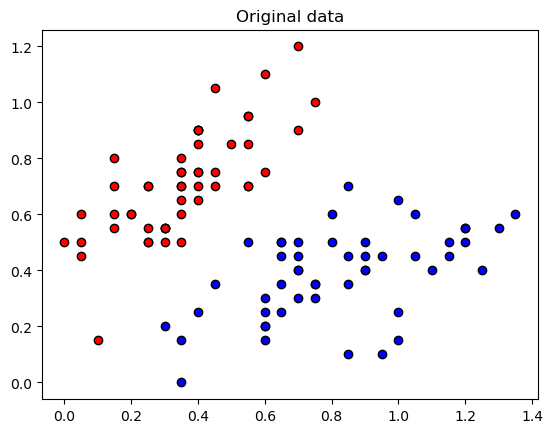

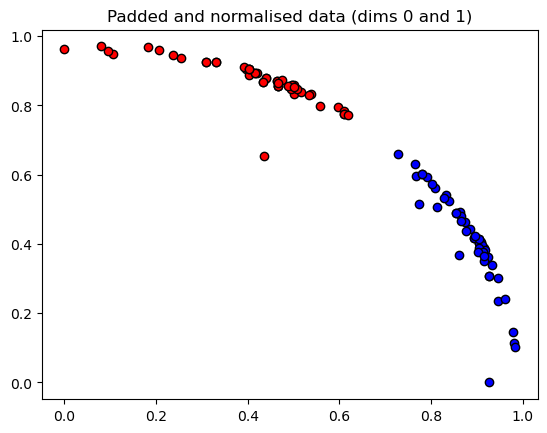

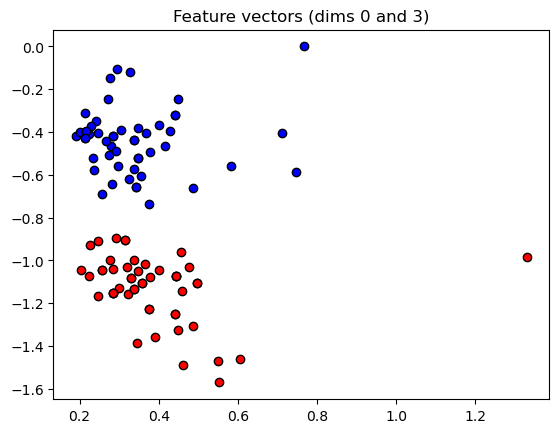

In [27]:
import matplotlib.pyplot as plt

plt.figure()
plt.scatter(X[:, 0][Y == 1], X[:, 1][Y == 1], c="b", marker="o", ec="k")
plt.scatter(X[:, 0][Y == -1], X[:, 1][Y == -1], c="r", marker="o", ec="k")
plt.title("Original data")
plt.show()

plt.figure()
dim1 = 0
dim2 = 1
plt.scatter(X_norm[:, dim1][Y == 1], X_norm[:, dim2][Y == 1], c="b", marker="o", ec="k")
plt.scatter(X_norm[:, dim1][Y == -1], X_norm[:, dim2][Y == -1], c="r", marker="o", ec="k")
plt.title(f"Padded and normalised data (dims {dim1} and {dim2})")
plt.show()

plt.figure()
dim1 = 0
dim2 = 3
plt.scatter(features[:, dim1][Y == 1], features[:, dim2][Y == 1], c="b", marker="o", ec="k")
plt.scatter(features[:, dim1][Y == -1], features[:, dim2][Y == -1], c="r", marker="o", ec="k")
plt.title(f"Feature vectors (dims {dim1} and {dim2})")
plt.show()

### 3.3: Train-Test Split

In [21]:
np.random.seed(0)
num_data = len(Y)
num_train = int(0.75 * num_data)
index = np.random.permutation(range(num_data))
feats_train = features[index[:num_train]]
Y_train = Y[index[:num_train]]
feats_val = features[index[num_train:]]
Y_val = Y[index[num_train:]]

# We need these later for plotting
X_train = X[index[:num_train]]
X_val = X[index[num_train:]]

### 3.4: Hyper-parameters

In [28]:
num_qubits = 2
num_layers = 6

weights_init = 0.01 * np.random.randn(num_layers, num_qubits, 3, requires_grad=True)
bias_init = np.array(0.0, requires_grad=True)

opt = qml.NesterovMomentumOptimizer(0.01)
batch_size = 5

### 3.5: Training Process

In [29]:
weights = weights_init
bias = bias_init
for it in range(60):
    # Update the weights by one optimizer step
    batch_index = np.random.randint(0, num_train, (batch_size,))
    feats_train_batch = feats_train[batch_index]
    Y_train_batch = Y_train[batch_index]
    weights, bias, _, _ = opt.step(cost, weights, bias, feats_train_batch, Y_train_batch)

    # Compute predictions on train and validation set
    predictions_train = np.sign(variational_classifier(weights, bias, feats_train.T))
    predictions_val = np.sign(variational_classifier(weights, bias, feats_val.T))

    # Compute accuracy on train and validation set
    acc_train = accuracy(Y_train, predictions_train)
    acc_val = accuracy(Y_val, predictions_val)

    if (it + 1) % 2 == 0:
        _cost = cost(weights, bias, features, Y)
        print(
            f"Iter: {it + 1:5d} | Cost: {_cost:0.7f} | "
            f"Acc train: {acc_train:0.7f} | Acc validation: {acc_val:0.7f}"
        )

Iter:     2 | Cost: 1.6800456 | Acc train: 0.4800000 | Acc validation: 0.5600000
Iter:     4 | Cost: 1.4003046 | Acc train: 0.4933333 | Acc validation: 0.5600000
Iter:     6 | Cost: 1.1166565 | Acc train: 0.4933333 | Acc validation: 0.5600000
Iter:     8 | Cost: 0.9870967 | Acc train: 0.4533333 | Acc validation: 0.6400000
Iter:    10 | Cost: 0.9919200 | Acc train: 0.5600000 | Acc validation: 0.4800000
Iter:    12 | Cost: 1.0068242 | Acc train: 0.5200000 | Acc validation: 0.4400000
Iter:    14 | Cost: 0.9532768 | Acc train: 0.5466667 | Acc validation: 0.4800000
Iter:    16 | Cost: 0.8860452 | Acc train: 0.7066667 | Acc validation: 0.6800000
Iter:    18 | Cost: 0.8552931 | Acc train: 0.8266667 | Acc validation: 0.8400000
Iter:    20 | Cost: 0.8309771 | Acc train: 0.8400000 | Acc validation: 1.0000000
Iter:    22 | Cost: 0.7807641 | Acc train: 0.8533333 | Acc validation: 0.8000000
Iter:    24 | Cost: 0.7447679 | Acc train: 0.6666667 | Acc validation: 0.6400000
Iter:    26 | Cost: 0.677520

### 3.6: Final Output Visualization

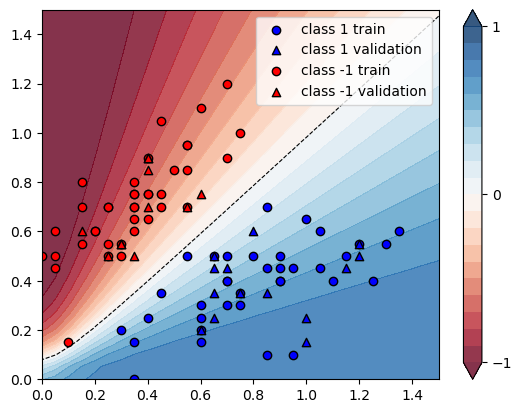

In [24]:
plt.figure()
cm = plt.cm.RdBu

# make data for decision regions
xx, yy = np.meshgrid(np.linspace(0.0, 1.5, 30), np.linspace(0.0, 1.5, 30))
X_grid = [np.array([x, y]) for x, y in zip(xx.flatten(), yy.flatten())]

# preprocess grid points like data inputs above
padding = 0.1 * np.ones((len(X_grid), 2))
X_grid = np.c_[X_grid, padding]  # pad each input
normalization = np.sqrt(np.sum(X_grid**2, -1))
X_grid = (X_grid.T / normalization).T  # normalize each input
features_grid = np.array([get_angles(x) for x in X_grid])  # angles are new features
predictions_grid = variational_classifier(weights, bias, features_grid.T)
Z = np.reshape(predictions_grid, xx.shape)

# plot decision regions
levels = np.arange(-1, 1.1, 0.1)
cnt = plt.contourf(xx, yy, Z, levels=levels, cmap=cm, alpha=0.8, extend="both")
plt.contour(xx, yy, Z, levels=[0.0], colors=("black",), linestyles=("--",), linewidths=(0.8,))
plt.colorbar(cnt, ticks=[-1, 0, 1])

# plot data
for color, label in zip(["b", "r"], [1, -1]):
    plot_x = X_train[:, 0][Y_train == label]
    plot_y = X_train[:, 1][Y_train == label]
    plt.scatter(plot_x, plot_y, c=color, marker="o", ec="k", label=f"class {label} train")
    plot_x = (X_val[:, 0][Y_val == label],)
    plot_y = (X_val[:, 1][Y_val == label],)
    plt.scatter(plot_x, plot_y, c=color, marker="^", ec="k", label=f"class {label} validation")

plt.legend()
plt.show()

## Final notes

Seeing how each block in the quantum and classical circuit change the state of the system really helps to monitor all the changes and consciously make the required changes. In the above circuit, RX gate can also be used in place of the RY gate. However, through careful calculations of system evolutions, the state preparation equations should be changed.

In the side of Classical computing, more layers or other models can be added or the hyper parameters and the optimization teechniques can be changed.